<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/7.%2020Q%20TFIM%20VQE%26VQNHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options
from functools import cache
# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

# Hamiltonian Diagonalization

$$ H =  Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [3]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(19)] + [bias for _ in range(20)]
operator_list = ["ZZIIIIIIIIIIIIIIIIII", "IZZIIIIIIIIIIIIIIIII", "IIZZIIIIIIIIIIIIIIII", "IIIZZIIIIIIIIIIIIIII", "IIIIZZIIIIIIIIIIIIII",
                 "IIIIIZZIIIIIIIIIIIII", "IIIIIIZZIIIIIIIIIIII", "IIIIIIIZZIIIIIIIIIII", "IIIIIIIIZZIIIIIIIIII", "IIIIIIIIIZZIIIIIIIII",
                 "IIIIIIIIIIZZIIIIIIII", "IIIIIIIIIIIZZIIIIIII", "IIIIIIIIIIIIZZIIIIII", "IIIIIIIIIIIIIZZIIIII", "IIIIIIIIIIIIIIZZIIII",
                 "IIIIIIIIIIIIIIIZZIII", "IIIIIIIIIIIIIIIIZZII", "IIIIIIIIIIIIIIIIIZZI", "IIIIIIIIIIIIIIIIIIZZ",
                 "XIIIIIIIIIIIIIIIIIII", "IXIIIIIIIIIIIIIIIIII", "IIXIIIIIIIIIIIIIIIII", "IIIXIIIIIIIIIIIIIIII", "IIIIXIIIIIIIIIIIIIII",
                 "IIIIIXIIIIIIIIIIIIII", "IIIIIIXIIIIIIIIIIIII", "IIIIIIIXIIIIIIIIIIII", "IIIIIIIIXIIIIIIIIIII", "IIIIIIIIIXIIIIIIIIII",
                 "IIIIIIIIIIXIIIIIIIII", "IIIIIIIIIIIXIIIIIIII", "IIIIIIIIIIIIXIIIIIII", "IIIIIIIIIIIIIXIIIIII", "IIIIIIIIIIIIIIXIIIII",
                 "IIIIIIIIIIIIIIIXIIII", "IIIIIIIIIIIIIIIIXIII", "IIIIIIIIIIIIIIIIIXII", "IIIIIIIIIIIIIIIIIIXI", "IIIIIIIIIIIIIIIIIIIX",]
hamiltonian_list = []
for i in range(39):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

# VQE (depth=1) in Noiseless Simulator

scipy minimize

## Ansatz

In [48]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize

In [49]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(19)] + [bias for _ in range(20)]
operator_list = ["ZZIIIIIIIIIIIIIIIIII", "IZZIIIIIIIIIIIIIIIII", "IIZZIIIIIIIIIIIIIIII", "IIIZZIIIIIIIIIIIIIII", "IIIIZZIIIIIIIIIIIIII",
                 "IIIIIZZIIIIIIIIIIIII", "IIIIIIZZIIIIIIIIIIII", "IIIIIIIZZIIIIIIIIIII", "IIIIIIIIZZIIIIIIIIII", "IIIIIIIIIZZIIIIIIIII",
                 "IIIIIIIIIIZZIIIIIIII", "IIIIIIIIIIIZZIIIIIII", "IIIIIIIIIIIIZZIIIIII", "IIIIIIIIIIIIIZZIIIII", "IIIIIIIIIIIIIIZZIIII",
                 "IIIIIIIIIIIIIIIZZIII", "IIIIIIIIIIIIIIIIZZII", "IIIIIIIIIIIIIIIIIZZI", "IIIIIIIIIIIIIIIIIIZZ",
                 "XIIIIIIIIIIIIIIIIIII", "IXIIIIIIIIIIIIIIIIII", "IIXIIIIIIIIIIIIIIIII", "IIIXIIIIIIIIIIIIIIII", "IIIIXIIIIIIIIIIIIIII",
                 "IIIIIXIIIIIIIIIIIIII", "IIIIIIXIIIIIIIIIIIII", "IIIIIIIXIIIIIIIIIIII", "IIIIIIIIXIIIIIIIIIII", "IIIIIIIIIXIIIIIIIIII",
                 "IIIIIIIIIIXIIIIIIIII", "IIIIIIIIIIIXIIIIIIII", "IIIIIIIIIIIIXIIIIIII", "IIIIIIIIIIIIIXIIIIII", "IIIIIIIIIIIIIIXIIIII",
                 "IIIIIIIIIIIIIIIXIIII", "IIIIIIIIIIIIIIIIXIII", "IIIIIIIIIIIIIIIIIXII", "IIIIIIIIIIIIIIIIIIXI", "IIIIIIIIIIIIIIIIIIIX",]
hamiltonian_list = []
for i in range(39):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [50]:
ansatz_zz_set = []
ansatz_x_set = []

In [51]:
def right_shifter(seq, num):
  return seq[20-num:20]+seq[0:20-num]

In [52]:
def left_shifter(seq, num):
  new_seq = []
  for i in range(num):
    new_seq.append(seq[20-num+i])
  for i in range(20-num):
    new_seq.append(seq[i])
  new_seq = np.array(new_seq)

  return new_seq

In [53]:
# ZZ measurement
seq_q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
seq_c = [19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]

for i in range(19):

  qbit = QuantumRegister(20)
  cbit = ClassicalRegister(20)
  ansatz = QuantumCircuit(qbit, cbit)

  params = ParameterVector("theta", length=39)
  it = iter(params)
  ansatz.h(range(0,20))

  ansatz.barrier()

  for i in range(0,20,2):
    ansatz.cx(i,i+1)
  for i in range(0,20,2):
    ansatz.rz(next(it), i+1)
  for i in range(0,20,2):
    ansatz.cx(i,i+1)

  for i in range(1,19,2):
    ansatz.cx(i,i+1)
  for i in range(1,19,2):
    ansatz.rz(next(it), i+1)
  for i in range(1,19,2):
    ansatz.cx(i,i+1)

  ansatz.barrier()

  for i in range(20):
    ansatz.rx(next(it), i)

  ansatz.measure(seq_q,right_shifter(seq_c, i))

  ansatz_zz_set.append(ansatz)

In [54]:
# X measurement
seq_q = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
seq_c = [19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]

for i in range(20):
  ansatz_prime = ansatz
  ansatz_prime.h(i)
  ansatz_prime.measure(seq_q,right_shifter(seq_c, i))

  ansatz_x_set.append(ansatz_prime)

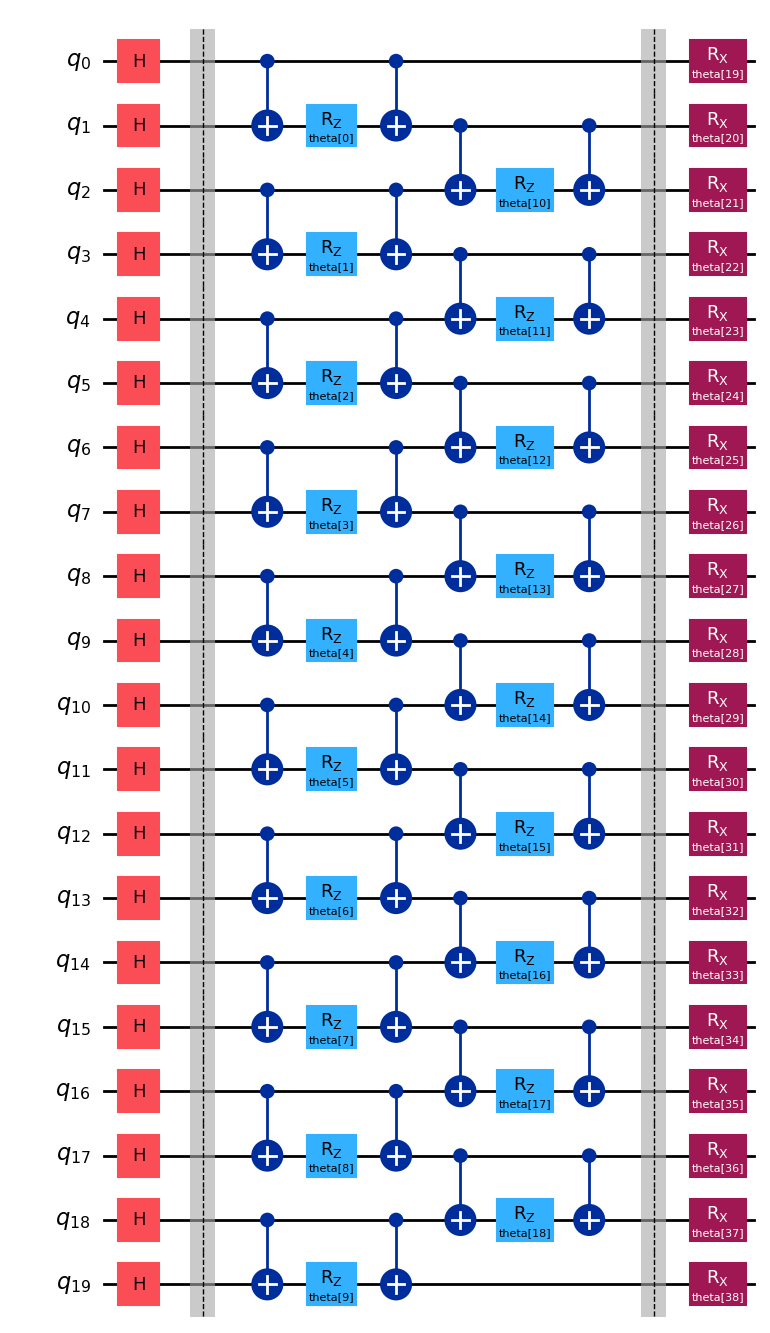

In [55]:
# Ansatz

ansatz = QuantumCircuit(20)

params = ParameterVector("theta", length=39)
it = iter(params)
ansatz.h(range(0,20))

ansatz.barrier()

for i in range(0,20,2):
  ansatz.cx(i,i+1)
for i in range(0,20,2):
  ansatz.rz(next(it), i+1)
for i in range(0,20,2):
  ansatz.cx(i,i+1)

for i in range(1,19,2):
  ansatz.cx(i,i+1)
for i in range(1,19,2):
  ansatz.rz(next(it), i+1)
for i in range(1,19,2):
  ansatz.cx(i,i+1)

ansatz.barrier()

for i in range(20):
  ansatz.rx(next(it), i)

ansatz.draw("mpl")

In [56]:
# Estimator & Sampler

estimator = Estimator()
sampler = Sampler()

## VQE Function

In [72]:
def cost_func_vqe(params_pqc):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params_pqc).result()
    return cost.values[0]

In [73]:
def build_callback_vqe(callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost_vqe = cost_func_vqe(current_vector)

    callback_dict["cost_history"].append(current_cost_vqe)

    print(current_cost_vqe)

  return callback

## 1st Step : VQE

In [74]:
local_minimum_list = []

for k in range(20):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.pi * np.random.random(39)

  callback = build_callback_vqe(callback_dict)

  options = dict()
  options["maxiter"] = 40
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])

  print(res.x)
  print()
  print()
  print()

-7.520705323850237
-11.53493418660927
-15.92693751140486
-16.26055606889794
-16.8901045017294
-17.951111887905498
-18.858145091727792
-18.982969862101886
-19.113855978893195
-19.180114899819607
-19.21446028010052
-19.230509479778053
-19.234727404623865
-19.2368209034219
-19.23770093414145
-19.238399689178117
-19.238830388495053
-19.2392292760753
-19.2397407835938
-19.240340723073405
-19.240757486749835
-19.24097739725853
-19.241060581137965
-19.24111975904884
-19.24119987524806
-19.24126626199791
-19.24130988775322
-19.24136017581126
-19.241435270982784
-19.241551202741853
-19.241711883905506
-19.241865123153474
-19.242030764910734
-19.242169040599727
-19.242231447566358
-19.24225731823796
-19.242276843892576


KeyboardInterrupt: 

In [ ]:
local_minimum_list

## VQNHE Function

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))

In [ ]:
# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:400]
  W2 = parameter[400:420]
  c = parameter[420]

  W1 = W1.reshape(20,20)
  W3 = W3.reshape(1,20)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  y = output_activate(c, a2)

  return y[0]

In [ ]:
# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(20):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def prob_zz_str(params_pqc, num):
  job = sampler.run(ansatz_zz_set[num], params_pqc).result()
  prob_string = job.quasi_dists[0]

  for i in range(2**20):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

@cache
def prob_x_str(params_pqc, num):
  job = sampler.run(ansatz_x_set[num], params_pqc).result()
  prob_string = job.quasi_dists[0]

  for i in range(2**20):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def ZZ_vqnhe(params_nn, params_pqc, num):
  prob_string = prob_zz_str(params_pqc, num)
  nnval = np.array([(neural_net(params_nn, left_shifter(d2b(j),num)))**2 for j in range(2**20)])

  expval = 0

  for k in range(2**20):
    if k // 2**18 == 0 or k // 2**18 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval

In [ ]:
def X_vqnhe(params_nn, params_pqc, num):
  prob_string = prob_x_str(params_pqc, num)
  nnval = np.array([neural_net(params_nn, left_shifter(d2b(j),num)) for j in range(2**20)])

  expval = 0

  for k in range(2**19):
    delt = prob_string[k] - prob_string[k+2**19]
    expval = expval + delt*nnval[k]*nnval[k+2**19]

  return expval

In [ ]:
def norm_vqnhe(params_nn, params_pqc):
  prob_string = prob_zz_str(params_pqc, 0)
  nnval = np.array([(neural_net(params_nn, left_shifter(d2b(j),0)))**2 for j in range(2**20)])

  expval = 0

  for k in range(2**20):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, params_pqc):
  expval = 0

  for i in range(19):
    expval = expval + ZZ_vqnhe(params_nn, params_pqc, i)

  for i in range(20):
    expval = expval - X_vqnhe(params_nn, params_pqc, i)


  expval = expval / norm_vqnhe(params_nn, params_pqc)

  return expval

In [ ]:
def build_callback_vqnhe(callback_dict, params_pqc):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost_vqnhe = cost_func_vqnhe(current_vector, params_pqc)

    callback_dict["cost_history"].append(current_cost_vqnhe)

    print(current_cost_vqnhe)

  return callback

## 2nd Step : VQNHE

In [ ]:
local_minimum_list = []

for k in range(50):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  #params_pqc = ????

  np.random.seed(k)
  x0 = 2 * np.pi * np.random.random(23)

  callback = build_callback_vqnhe(callback_dict, params_pqc)

  options = dict()
  options["maxiter"] = 400
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(params_pqc),
    method="bfgs",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  local_minimum_list.append(local_minimum_dict[-1])

Optimization terminated successfully.
         Current function value: -9.760508
         Iterations: 28
         Function evaluations: 720
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: -9.685603
         Iterations: 27
         Function evaluations: 672
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: -12.014575
         Iterations: 37
         Function evaluations: 984
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: -14.321977
         Iterations: 47
         Function evaluations: 1272
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: -11.942713
         Iterations: 38
         Function evaluations: 960
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: -11.942713
         Iterations: 42
         Function ev

In [ ]:
local_minimum_list

In [ ]:
np.min(local_minimum_list)